<a href="https://colab.research.google.com/github/AmlanAlok/instacart-2017-project/blob/XGBoost-3/Instacart_2017_XGBoost_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For data manipulation
import pandas as pd    
import xgboost
from sklearn.model_selection import train_test_split
import time

import numpy as np # algebra & calculus
from google.colab import drive
drive.mount('/content/drive/')

%cd 'drive/MyDrive/9-Projects/1-ML-Instacart'


# Garbage Collector to free up memory
import gc                         
gc.enable()  

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/9-Projects/1-ML-Instacart


Reading input

In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")

print("aisles: ",aisles.shape)
print("departments: " ,departments.shape)
print("orders: ",orders.shape)
print("products: ",products.shape)
print("order_products_prior: ",order_products_prior.shape)
print("order_products_train: ",order_products_train.shape)

aisles:  (134, 2)
departments:  (21, 2)
orders:  (3421083, 7)
products:  (49688, 4)
order_products_prior:  (32434489, 4)
order_products_train:  (1384617, 4)


Reducing size of orders for faster computation

In [3]:
orders = orders.loc[orders.user_id.isin(orders.user_id.drop_duplicates().sample(frac=0.1, random_state=25))] 
orders.shape

(340739, 7)

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
54,2565571,7,prior,1,3,9,NaN
55,2402008,7,prior,2,1,19,30.0
56,121053,7,prior,3,0,18,30.0
57,1695742,7,prior,4,2,10,9.0
58,3321109,7,prior,5,5,18,3.0


Changing some columns from object type to Category

In [5]:
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')

In [6]:
op = orders.merge(order_products_prior, on='order_id', how='inner')
print('op.shape', op.shape)
op.head()

op.shape (3220328, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2565571,7,prior,1,3,9,NaN,45628,1,0
1,2565571,7,prior,1,3,9,NaN,39275,2,0
2,2565571,7,prior,1,3,9,NaN,6361,3,0
3,2565571,7,prior,1,3,9,NaN,45066,4,0
4,2565571,7,prior,1,3,9,NaN,13249,5,0


In [7]:
op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220328 entries, 0 to 3220327
Data columns (total 10 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   eval_set                category
 3   order_number            int64   
 4   order_dow               int64   
 5   order_hour_of_day       int64   
 6   days_since_prior_order  float64 
 7   product_id              int64   
 8   add_to_cart_order       int64   
 9   reordered               int64   
dtypes: category(1), float64(1), int64(8)
memory usage: 248.8 MB


In [8]:
op['reordered'] = op['reordered'].astype('int8')
op['order_dow'] = op['order_dow'].astype('int8')
op['order_hour_of_day'] = op['order_hour_of_day'].astype('int8')
op['add_to_cart_order'] = op['add_to_cart_order'].astype('int8')
op['days_since_prior_order'] = op['days_since_prior_order'].astype('float16')

In [9]:
op.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3220328 entries, 0 to 3220327
Data columns (total 10 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int64   
 1   user_id                 int64   
 2   eval_set                category
 3   order_number            int64   
 4   order_dow               int8    
 5   order_hour_of_day       int8    
 6   days_since_prior_order  float16 
 7   product_id              int64   
 8   add_to_cart_order       int8    
 9   reordered               int8    
dtypes: category(1), float16(1), int64(4), int8(4)
memory usage: 144.3 MB


1. USER PREDICTORS




In [10]:
# Create distinct groups for each user, identify the highest order number in each group

# How many times has a user placed orders?

user = op.groupby('user_id')['order_number'].max().to_frame('u_total_orders')
print('user.shape =', user.shape)
print('total users in the prior dataset =', user.shape[0])
user.head()

user.shape = (20621, 1)
total users in the prior dataset = 20621


,u_total_orders
user_id,
7,20
14,13
22,15
24,18
29,18


In [11]:
# Resetting index
user = user.reset_index()
user.head()

,user_id,u_total_orders
0,7,20
1,14,13
2,22,15
3,24,18
4,29,18


In [12]:
# For a given user what is the mean of the reordered column?
# For a user, what is the ratio of reordered item to total items ordered?

u_reorder = op.groupby('user_id')['reordered'].mean().to_frame('u_reordered_ratio')
u_reorder = u_reorder.reset_index()
print('u_reorder.shape', u_reorder.shape)
u_reorder.head()

u_reorder.shape (20621, 2)


,user_id,u_reordered_ratio
0,7,0.669903
1,14,0.323810
2,22,0.507246
3,24,0.526316
4,29,0.702222


In [13]:
user = user.merge(u_reorder, on='user_id', how='left')

del u_reorder
gc.collect()

print('user.shape =', user.shape)
user.head()

user.shape = (20621, 3)


,user_id,u_total_orders,u_reordered_ratio
0,7,20,0.669903
1,14,13,0.323810
2,22,15,0.507246
3,24,18,0.526316
4,29,18,0.702222


2. PRODUCT PREDICTORS

In [14]:
# For each product, count the number of orders in which it was present
prd = op.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')
prd = prd.reset_index()
print('prd.shape =', prd.shape)
prd.head()

prd.shape = (41265, 2)


,product_id,p_total_purchases
0,1,205
1,2,13
2,3,15
3,4,37
4,6,1


In [15]:
p_reorder = op.groupby('product_id').filter(lambda x: x.shape[0] >260)
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (2182927, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
1,2565571,7,prior,1,3,9,NaN,39275,2,0
2,2565571,7,prior,1,3,9,NaN,6361,3,0
3,2565571,7,prior,1,3,9,NaN,45066,4,0
4,2565571,7,prior,1,3,9,NaN,13249,5,0
5,2565571,7,prior,1,3,9,NaN,31683,6,0


In [16]:
p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder = p_reorder.reset_index()
print('p_reorder.shape =', p_reorder.shape)
p_reorder.head()

p_reorder.shape = (2170, 2)


,product_id,p_reorder_ratio
0,10,0.535849
1,34,0.605463
2,45,0.631891
3,79,0.536458
4,95,0.176471


In [17]:
#Merge the prd DataFrame with reorder
prd = prd.merge(p_reorder, on='product_id', how='left')

#delete the reorder DataFrame
del p_reorder
gc.collect()

print('prd.shape =', prd.shape)
prd.head()

prd.shape = (41265, 3)


,product_id,p_total_purchases,p_reorder_ratio
0,1,205,NaN
1,2,13,NaN
2,3,15,NaN
3,4,37,NaN
4,6,1,NaN


In [18]:
prd['p_reorder_ratio'] = prd['p_reorder_ratio'].fillna(value=0)
prd.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,205,0.0
1,2,13,0.0
2,3,15,0.0
3,4,37,0.0
4,6,1,0.0


3. USER-PRODUCT PREDICTORS

In [19]:
# For a user, counting the number of products they bought of each type

uxp = op.groupby(['user_id', 'product_id'])['order_id'].count().to_frame('uxp_total_bought')
uxp.head()

uxp_total_bought
user_id product_id                  
7       274                        1
        519                        2
        4920                       7
        4945                       3
        6361                       5

In [20]:
uxp = uxp.reset_index()
print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (1315032, 3)


,user_id,product_id,uxp_total_bought
0,7,274,1
1,7,519,2
2,7,4920,7
3,7,4945,3
4,7,6361,5


In [21]:
times = op.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
print('times.shape =', times.shape)
times.head()

times.shape = (1315032, 1)


Times_Bought_N
user_id product_id                
7       274                      1
        519                      2
        4920                     7
        4945                     3
        6361                     5

In [22]:
total_orders = op.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders = total_orders.reset_index()
print('total_orders.shape =', total_orders.shape)
total_orders.head()

total_orders.shape = (20621, 2)


,user_id,total_orders
0,7,20
1,14,13
2,22,15
3,24,18
4,29,18


In [23]:
# Amongsnt all the orders a user placed, we are finding the order number where 
# a certain product was bought for the first time

first_order_no = op.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no = first_order_no.reset_index()
print('first_order_no.shape =', first_order_no.shape)
first_order_no.head()

first_order_no.shape = (1315032, 3)


,user_id,product_id,first_order_number
0,7,274,2
1,7,519,1
2,7,4920,2
3,7,4945,16
4,7,6361,1


In [24]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
print('span.shape =', span.shape)
span.head()

span.shape = (1315032, 4)


,user_id,total_orders,product_id,first_order_number
0,7,20,274,2
1,7,20,519,1
2,7,20,4920,2
3,7,20,4945,16
4,7,20,6361,1


In [25]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
print('span.shape =', span.shape)
span.head()

span.shape = (1315032, 5)


,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,7,20,274,2,19
1,7,20,519,1,20
2,7,20,4920,2,19
3,7,20,4945,16,5
4,7,20,6361,1,20


In [26]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (1315032, 6)


,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,7,274,1,20,2,19
1,7,519,2,20,1,20
2,7,4920,7,20,2,19
3,7,4945,3,20,16,5
4,7,6361,5,20,1,20


In [27]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio.head()

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,7,274,1,20,2,19,0.052632
1,7,519,2,20,1,20,0.100000
2,7,4920,7,20,2,19,0.368421
3,7,4945,3,20,16,5,0.600000
4,7,6361,5,20,1,20,0.250000


In [28]:
# dropping all unrequired columns

uxp_ratio = uxp_ratio.drop(['Times_Bought_N', 'total_orders', 'first_order_number', 'Order_Range_D'], axis=1)
print('uxp_ratio.shape =', uxp_ratio.shape)
uxp_ratio.head()

uxp_ratio.shape = (1315032, 3)


,user_id,product_id,uxp_reorder_ratio
0,7,274,0.052632
1,7,519,0.100000
2,7,4920,0.368421
3,7,4945,0.600000
4,7,6361,0.250000


In [29]:
#Remove temporary DataFrames
del [times, first_order_no, span]

In [30]:
uxp = uxp.merge(uxp_ratio, on=['user_id', 'product_id'], how='left')

del uxp_ratio

print('uxp.shape =', uxp.shape)
uxp.head()

uxp.shape = (1315032, 4)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio
0,7,274,1,0.052632
1,7,519,2,0.100000
2,7,4920,7,0.368421
3,7,4945,3,0.600000
4,7,6361,5,0.250000


MERGE ALL FEATURES

In [31]:
# Merging uxp features with the user features

data = uxp.merge(user, on='user_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (1315032, 6)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio
0,7,274,1,0.052632,20,0.669903
1,7,519,2,0.100000,20,0.669903
2,7,4920,7,0.368421,20,0.669903
3,7,4945,3,0.600000,20,0.669903
4,7,6361,5,0.250000,20,0.669903


In [32]:
# Merge uxp & user features (the new DataFrame) with prd features

data = data.merge(prd, on='product_id', how='left')
print('data.shape =', data.shape)
data.head()

data.shape = (1315032, 8)


,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,7,274,1,0.052632,20,0.669903,232,0.000000
1,7,519,2,0.100000,20,0.669903,111,0.000000
2,7,4920,7,0.368421,20,0.669903,8126,0.666010
3,7,4945,3,0.600000,20,0.669903,599,0.732888
4,7,6361,5,0.250000,20,0.669903,333,0.756757


In [33]:
# del op, user, prd, uxp
del user, prd, uxp
gc.collect()

252

TRAIN DF

In [34]:
print('orders.shape =', orders.shape)
orders['eval_set'].unique()

orders.shape = (340739, 7)


['prior', 'train', 'test']
Categories (3, object): ['prior', 'test', 'train']

In [35]:
print('op.shape =', op.shape)
op = op.drop(['eval_set', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order'], axis=1)
op.head()

op.shape = (3220328, 10)


,user_id,product_id,reordered
0,7,45628,0
1,7,39275,0
2,7,6361,0
3,7,45066,0
4,7,13249,0


In [36]:
opjoin = op.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin.shape =', opjoin.shape)

opjoin.shape = (3220328, 9)


In [37]:
del op

In [38]:
opjoin.head()

,user_id,product_id,reordered,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,7,45628,0,5,0.25,20,0.669903,21,0.000000
1,7,39275,0,4,0.20,20,0.669903,9882,0.623760
2,7,6361,0,5,0.25,20,0.669903,333,0.756757
3,7,45066,0,4,0.20,20,0.669903,7990,0.734919
4,7,13249,0,1,0.05,20,0.669903,1446,0.772476


In [39]:
opjoin['reordered'].unique()

array([0, 1], dtype=int8)

In [40]:
opjoin = opjoin.set_index(['user_id', 'product_id'])
opjoin.head()

reordered  uxp_total_bought  uxp_reorder_ratio  \
user_id product_id                                                   
7       45628               0                 5               0.25   
        39275               0                 4               0.20   
        6361                0                 5               0.25   
        45066               0                 4               0.20   
        13249               0                 1               0.05   

                    u_total_orders  u_reordered_ratio  p_total_purchases  \
user_id product_id                                                         
7       45628                   20           0.669903                 21   
        39275                   20           0.669903               9882   
        6361                    20           0.669903                333   
        45066                   20           0.669903               7990   
        13249                   20           0.669903               1446   

                    p_reorder_ratio  
user_id product_id                   
7       45628              0.000000  
        39275              0.623760  
        6361               0.756757  
        45066              0.734919  
        13249              0.772476

In [41]:
opjoin.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3220328 entries, (7, 45628) to (206202, 46908)
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   reordered          int8   
 1   uxp_total_bought   int64  
 2   uxp_reorder_ratio  float64
 3   u_total_orders     int64  
 4   u_reordered_ratio  float64
 5   p_total_purchases  int64  
 6   p_reorder_ratio    float64
dtypes: float64(3), int64(3), int8(1)
memory usage: 170.9 MB


TEST DF 

In [53]:
op_test = orders.merge(order_products_train, on='order_id', how='inner')
print('op_test.shape', op_test.shape)
op_test.head()

op_test.shape (137230, 10)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,525192,7,train,21,2,11,6.0,12053,1,0
1,525192,7,train,21,2,11,6.0,47272,2,1
2,525192,7,train,21,2,11,6.0,37999,3,1
3,525192,7,train,21,2,11,6.0,13198,4,1
4,525192,7,train,21,2,11,6.0,43967,5,1


In [54]:
op_test = op_test.drop(['eval_set', 'order_id', 'order_number', 'order_dow', 'order_hour_of_day', 'days_since_prior_order', 'add_to_cart_order'], axis=1)
op_test.head()

,user_id,product_id,reordered
0,7,12053,0
1,7,47272,1
2,7,37999,1
3,7,13198,1
4,7,43967,1


In [55]:
expected_y_df = op_test
expected_y_df = expected_y_df.rename(columns={"reordered": "expected_y"})
print('expected_y_df.shape =', expected_y_df.shape)
expected_y_df.head()

expected_y_df.shape = (137230, 3)


,user_id,product_id,expected_y
0,7,12053,0
1,7,47272,1
2,7,37999,1
3,7,13198,1
4,7,43967,1


In [56]:
opjoin_test = op_test.merge(data, on=['user_id', 'product_id'], how='left')
print('opjoin_test.shape =', opjoin_test.shape)

opjoin_test.shape = (137230, 9)


In [57]:
opjoin_test = opjoin_test.drop('reordered', axis=1)
opjoin_test.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,u_total_orders,u_reordered_ratio,p_total_purchases,p_reorder_ratio
0,7,12053,NaN,NaN,NaN,NaN,NaN,NaN
1,7,47272,4.0,0.235294,20.0,0.669903,51.0,0.000000
2,7,37999,5.0,0.250000,20.0,0.669903,63.0,0.000000
3,7,13198,8.0,0.421053,20.0,0.669903,1240.0,0.623387
4,7,43967,6.0,0.315789,20.0,0.669903,559.0,0.597496


In [58]:
opjoin_test = opjoin_test.set_index(['user_id', 'product_id'])
opjoin_test.head()

uxp_total_bought  uxp_reorder_ratio  u_total_orders  \
user_id product_id                                                        
7       12053                    NaN                NaN             NaN   
        47272                    4.0           0.235294            20.0   
        37999                    5.0           0.250000            20.0   
        13198                    8.0           0.421053            20.0   
        43967                    6.0           0.315789            20.0   

                    u_reordered_ratio  p_total_purchases  p_reorder_ratio  
user_id product_id                                                         
7       12053                     NaN                NaN              NaN  
        47272                0.669903               51.0         0.000000  
        37999                0.669903               63.0         0.000000  
        13198                0.669903             1240.0         0.623387  
        43967                0.669903              559.0         0.597496

Build Model

In [63]:
import xgboost
from sklearn.model_selection import train_test_split
# data_train.loc[:, 'reordered'] = data_train.reordered.fillna(0)
# data_train.head()

In [64]:
########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(opjoin.drop('reordered', axis=1), opjoin.reordered,
                                                    test_size=0.2, random_state=42)

[0]	train-logloss:0.642366
[10]	train-logloss:0.421892
[20]	train-logloss:0.361509
[30]	train-logloss:0.343722
[40]	train-logloss:0.337936
[50]	train-logloss:0.336116
[60]	train-logloss:0.335691
[70]	train-logloss:0.335458
[79]	train-logloss:0.335391


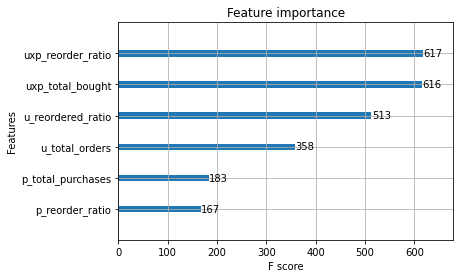

In [65]:
############################
## INITIATE AND TRAIN MODEL
############################

d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [66]:
del [X_train, X_val, y_train, y_val]
gc.collect()

87

In [67]:
pred = xgboost.DMatrix(opjoin_test)

prediction = opjoin_test.reset_index()
prediction = prediction[['product_id', 'user_id']]

prediction["reordered_predicted"] = (bst.predict(pred) > 0.15).astype(int)
prediction

,product_id,user_id,reordered_predicted
0,12053,7,0
1,47272,7,1
2,37999,7,1
3,13198,7,1
4,43967,7,1
...,...,...,...
137225,35221,206199,0
137226,7103,206199,1
137227,18345,206199,0
137228,18952,206199,1


In [68]:
tally = pd.merge(prediction, expected_y_df, on=['user_id', 'product_id'], how='inner')
tally.head()

,product_id,user_id,reordered_predicted,expected_y
0,12053,7,0,0
1,47272,7,1,1
2,37999,7,1,1
3,13198,7,1,1
4,43967,7,1,1


In [69]:
tally.head(40)

,product_id,user_id,reordered_predicted,expected_y
0,12053,7,0,0
1,47272,7,1,1
2,37999,7,1,1
3,13198,7,1,1
4,43967,7,1,1
5,40852,7,1,1
6,17638,7,1,1
7,29894,7,0,1
8,45066,7,1,1
9,11042,14,0,0


In [70]:
compare = np.where(tally["reordered_predicted"] == tally["expected_y"], True, False)

tally['compare'] = compare
tally.head()

,product_id,user_id,reordered_predicted,expected_y,compare
0,12053,7,0,0,True
1,47272,7,1,1,True
2,37999,7,1,1,True
3,13198,7,1,1,True
4,43967,7,1,1,True


In [71]:
tally.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137230 entries, 0 to 137229
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   product_id           137230 non-null  int64
 1   user_id              137230 non-null  int64
 2   reordered_predicted  137230 non-null  int64
 3   expected_y           137230 non-null  int64
 4   compare              137230 non-null  bool 
dtypes: bool(1), int64(4)
memory usage: 5.4 MB


In [72]:
true_count = tally['compare'].sum()
true_count

113173

In [73]:
false_count = len(tally['compare'])
false_count

137230

In [74]:
accuracy = (true_count/(len(tally['compare'])))*100
print('Accuracy =', accuracy, '%')

Accuracy = 82.46957662318735 %


In [75]:
tally.head(40)

,product_id,user_id,reordered_predicted,expected_y,compare
0,12053,7,0,0,True
1,47272,7,1,1,True
2,37999,7,1,1,True
3,13198,7,1,1,True
4,43967,7,1,1,True
5,40852,7,1,1,True
6,17638,7,1,1,True
7,29894,7,0,1,False
8,45066,7,1,1,True
9,11042,14,0,0,True
